# Create climate files for Echam2 sims

Notebook to create LPJ-GUESS EarthShape site simulation climate files from Echam5 time-slice data.
The notebook is creating domain wide input data and also location data.

Note, for some parts you also need `cdo` and `nco` installed on the machine.

2019-09-30, christian.werner@kit.edu


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [30]:
import cftime
import xarray as xr
import glob
import numpy as np
import matplotlib.pylab as plt

from collections import OrderedDict

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pathlib import Path

In [5]:
INPATH = Path.cwd() / '..' / 'raw_2nd_download'

ts_dirs = [x for x in INPATH.iterdir() if x.is_dir()]
tss = [x.name for x in ts_dirs]
tss

['pre_industrial',
 'middle_miocene',
 'middle_holocene',
 'late_miocene',
 'pliocene',
 'present_day',
 'lgm']

In [6]:
# we limit the echam5 data to these timesteps
custom_bds = {'present_day': (197801, 200012),
              'pre_industrial': (100801, 101712),
              'middle_holocene': (100801, 101712),
              'lgm': (100901, 101812),
              'pliocene': (100601, 101512),
              'late_miocene': (101001, 101912),
              'middle_miocene': (100501, 100712)      # only three years ?!?
             }

# default duration: last 10 years

In [9]:
def filter_ts(files, bds=None):
    files2 = []
    for f in files:
        if bds:
            t = f.name.split('.')[0].split('_')[-1]
            if int(t) >= bds[0] and int(t) <= bds[1]:
                print(t, end=' ')
                files2.append(f)
        else:
            files2.append(f)
    print()
    return files2

In [8]:
%%time
vars = ['aprt','temp2','srads']

for ts in ts_dirs:
    dsL = []
    print(ts.name, len(sorted(ts.glob('*.nc'))))
    
    with xr.open_mfdataset(filter_ts(sorted(ts.glob('*.nc')), bds=custom_bds[ts.name]), 
                           decode_times=False) as ds:
        ds[vars].to_netcdf(f'new_echam5_{ts.name}_daily.nc', mode='w')

pre_industrial 150
100801 100802 100803 100804 100805 100806 100807 100808 100809 100810 100811 100812 100901 100902 100903 100904 100905 100906 100907 100908 100909 100910 100911 100912 101001 101002 101003 101004 101005 101006 101007 101008 101009 101010 101011 101012 101101 101102 101103 101104 101105 101106 101107 101108 101109 101110 101111 101112 101201 101202 101203 101204 101205 101206 101207 101208 101209 101210 101211 101212 101301 101302 101303 101304 101305 101306 101307 101308 101309 101310 101311 101312 101401 101402 101403 101404 101405 101406 101407 101408 101409 101410 101411 101412 101501 101502 101503 101504 101505 101506 101507 101508 101509 101510 101511 101512 101601 101602 101603 101604 101605 101606 101607 101608 101609 101610 101611 101612 101701 101702 101703 101704 101705 101706 101707 101708 101709 101710 101711 101712 
middle_miocene 82
100501 100502 100503 100504 100505 100506 100507 100508 100509 100510 100511 100512 100601 100602 100603 100604 100605 100

## Evaluate some of the original data

92.06575342465753
1978-01-01T00:00:00.000000000 2000-12-31T18:00:00.000000000


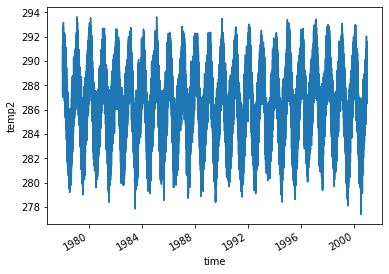

In [12]:
# plot present day
with xr.open_dataset('new_echam5_present_day_daily.nc', decode_times=True) as ds:
    ds['temp2'].mean(dim=['lat','lon']).plot()
print(len(ds.time)/365.0)
print(min(ds.time.values), max(ds.time.values))

pre_industrial 3653
middle_miocene 1095
middle_holocene 3653
late_miocene 3652
pliocene 3652
present_day 33604
lgm 3652


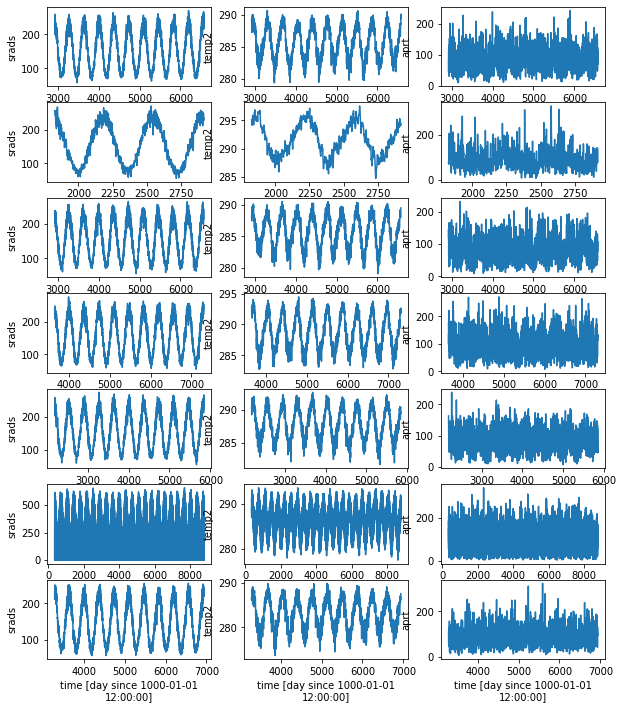

In [13]:
fig, axs = plt.subplots(nrows=len(tss), ncols=3, figsize=(10, 12))

for i, ts in enumerate(tss):
    with xr.open_dataset(f'new_echam5_{ts}_daily.nc', decode_times=False) as ds:
        print(ts, len(ds.time))
        # .isel(time=slice(-int(3650*1.0), None))
        ds['srads'].mean(dim=['lat','lon']).plot(ax=axs[i,0])
        ds['temp2'].mean(dim=['lat','lon']).plot(ax=axs[i,1])
        ds['aprt'].mean(dim=['lat','lon']).plot(ax=axs[i,2])    

In [26]:
# days in a month
days = [31,28,31,30,31,30,31,31,30,31,30,31]

**Use `cdo` to compute monahtly average files for present day echam5 sims** 

uncomment to run cell...

In [22]:
#!cdo ymonmean echam5_present_day_daily.nc monavg2.nc

In [14]:
e5clim = xr.open_dataset(f'monavg2.nc')

## Create monthly bias-corretion for Echam5 data

In [22]:
# monthly climatologies derived from ERA-INTERIM data
era1 = xr.open_dataset('FSDS.ERA_0.5deg_1979-2014CE_monClim.nc', decode_times=False)
era2 = xr.open_dataset('PRECT.ERA_0.5deg_1979-2014CE_monClim.nc', decode_times=False)
era3 = xr.open_dataset('TS.ERA_0.5deg_1979-2014CE_monClim.nc', decode_times=False)
eraclim = xr.merge([era1, era2, era3])
eraclim

<xarray.Dataset>
Dimensions:  (lat: 100, lon: 40, time: 12)
Coordinates:
  * lon      (lon) float64 -79.75 -79.25 -78.75 -78.25 ... -61.25 -60.75 -60.25
  * lat      (lat) float64 -59.75 -59.25 -58.75 -58.25 ... -11.25 -10.75 -10.25
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    FSDS     (time, lat, lon) float64 ...
    PRECT    (time, lat, lon) float64 ...
    TS       (time, lat, lon) float64 ...

In [18]:
# derive bias correction (division for rad, precip; substraction for temp)
b1 = eraclim['FSDS'].values / e5clim['srads'].values
b2 = eraclim['PRECT'].values / e5clim['aprt'].values
b3 = eraclim['TS'].values - e5clim['temp2'].values

bias = e5clim.copy(deep=True)
bias['srads'][:] = b1
bias['aprt'][:] = b2
bias['temp2'][:] = b3 + 273.15
bias

<xarray.Dataset>
Dimensions:  (lat: 100, lon: 40, time: 12)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31T09:00:00 ... 2000-12-31T09:00:00
  * lon      (lon) float64 -79.75 -79.25 -78.75 -78.25 ... -61.25 -60.75 -60.25
  * lat      (lat) float64 -59.75 -59.25 -58.75 -58.25 ... -11.25 -10.75 -10.25
Data variables:
    aprt     (time, lat, lon) float32 0.94847155 0.9547922 ... 0.7854356
    temp2    (time, lat, lon) float32 -0.13547969 -0.13888733 ... -1.4677798
    srads    (time, lat, lon) float32 1.2933383 1.2924128 ... 1.1765301 1.181399
Attributes:
    CDI:               Climate Data Interface version 1.9.2 (http://mpimet.mp...
    history:           Tue May 28 01:01:15 2019: cdo ymonmean echam5_present_...
    source:            ECHAM5.4
    institution:       Max-Planck-Institute for Meteorology
    Conventions:       CF-1.0, + local extensions
    title:             t004
    echam_version:     5.4.01-wiso
    advection:         Lin & Rood
    physics:           Modif

**Quick visualization of temperature bias correction**

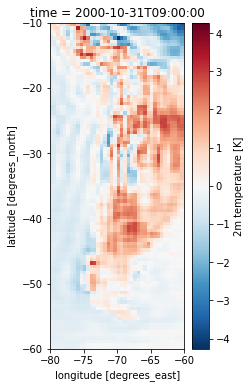

In [21]:
# use any random timestep (here step 10 aka position 9)
bias.temp2[9].plot(figsize=(3,6));

## Create new_echam5 files (10yr duration)

Due to varying length of valid echam5 raw data we clip the data to 10yr and repeat it.

In [27]:
DURATION=10

for i, ts in enumerate(tss):
    double_tseries = False
    if ts in ['present_day']:
        continue
    
    with xr.open_dataset(f'new_echam5_{ts}_daily.nc', decode_times=False) as ds:
        print(ts, len(ds.time))
        
        d_bias = {}
        for v in ds.data_vars:

            # create bias array
            l = []
            for i, d in enumerate(days):
                l.append( np.stack([bias[v][i]]* d) )

            d_bias[v] = np.vstack([np.vstack(l)]*DURATION)
            
            length = min(sum(days)*DURATION, len(ds[v].time))
            if v in ['temp2']:
                ds[v][:length] = ds[v][:length] + d_bias[v][:length]
            else:
                ds[v][:length] = ds[v][:length] * d_bias[v][:length]
        
        # output / biascorrected
        ds.isel(time=slice(0,length)).to_netcdf(f'biascorrected/new_echam5_{ts}_daily.nc')


pre_industrial 3653
middle_miocene 1095
middle_holocene 3653
late_miocene 3652
pliocene 3652
lgm 3652


In [28]:
! ls -al biascorrected

total 1506168
drwxr-xr-x  2 65536 65536      4096 Jul 18 07:33 .
drwxr-xr-x 15 65536 65536      4096 Sep 30 08:19 ..
-rw-r--r--  1 65536 65536 122684710 May 28 15:47 echam5_late_miocene_daily.nc
-rw-r--r--  1 65536 65536 122684701 May 29 08:37 echam5_lgm_daily.nc
-rw-r--r--  1 65536 65536 122684710 May 29 08:37 echam5_middle_miocene_daily.nc
-rw-r--r--  1 65536 65536 122684706 May 29 08:37 echam5_pliocene_daily.nc
-rw-r--r--  1 65536 65536 122684744 May 29 08:37 echam5_pre_industrial_daily.nc
-rw-r--r--  1 65536 65536 175252484 Sep 30 08:20 new_echam5_late_miocene_daily.nc
-rw-r--r--  1 65536 65536 175252465 Sep 30 08:20 new_echam5_lgm_daily.nc
-rw-r--r--  1 65536 65536 175252487 Sep 30 08:20 new_echam5_middle_holocene_daily.nc
-rw-r--r--  1 65536 65536  52592046 Sep 30 08:20 new_echam5_middle_miocene_daily.nc
-rw-r--r--  1 65536 65536 175252480 Sep 30 08:20 new_echam5_pliocene_daily.nc
-rw-r--r--  1 65536 65536 175252518 Sep 30 08:20 new_echam5_pre_industrial_daily.nc


### Visualize a bias correction

ds1: Echam5 Pliocene daily data  
ds2: Bias-corrected data


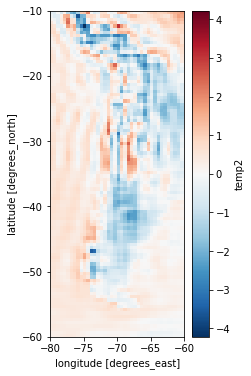

In [34]:
ds1 = xr.open_dataset('new_echam5_pliocene_daily.nc', decode_times=False)
ds2 = xr.open_dataset('biascorrected/new_echam5_pliocene_daily.nc', decode_times=False)
diff = ds1 - ds2
diff.mean(dim='time').temp2.plot(figsize=(3,6));

**Select an EarthShape focussite location (grid cell) and plot time-series**

Left: daily orighinal and bias-corrected data 

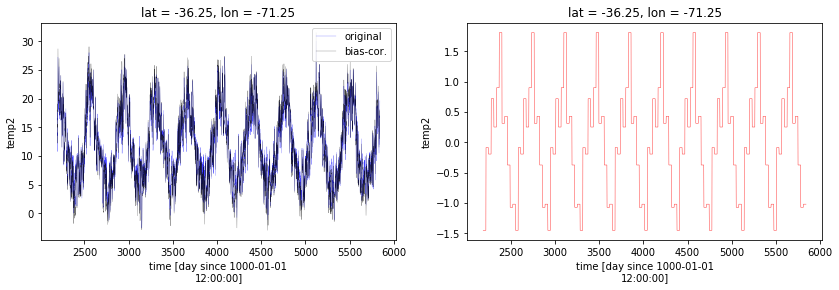

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

(ds1.sel(lon=[-71.25], lat=[-36.25]).temp2 - 273.15).plot(ax=ax[0], c='b', alpha=.75, lw=.25, label='original')
(ds2.sel(lon=[-71.25], lat=[-36.25]).temp2 - 273.15).plot(ax=ax[0], c='k', alpha=.75, lw=.25, label='bias-cor.')
(ds1-ds2).sel(lon=[-71.25], lat=[-36.25]).temp2.plot(ax=ax[1], c='red', alpha=.75, lw=.5);
ax[0].legend();

In [86]:
import pandas as pd
df_a = (ds1.sel(lon=[-71.25], lat=[-36.25]).temp2 - 273.15).to_dataframe().reset_index()
df_b = (ds2.sel(lon=[-71.25], lat=[-36.25]).temp2 - 273.15).to_dataframe().reset_index()
df_a = df_a[['time', 'temp2']]
df_b = df_b[['time', 'temp2']]
df_a.columns = ['time', 'temp2_orig']
df_b.columns = ['time', 'temp2_biascor']

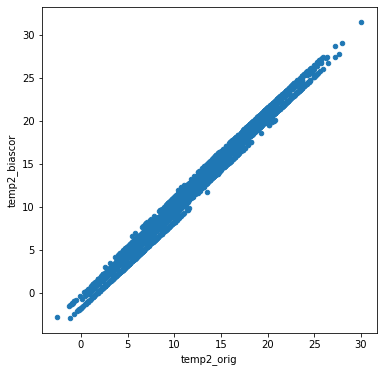

In [94]:
df = pd.merge(df_a, df_b)
df.plot.scatter('temp2_orig', 'temp2_biascor', figsize=(6,6));

# Produce LPJ-GUESS compatible climate files 

## Define coordinates and conversion factors

In [98]:
# fix file properties
res = 0.25
NODATA = -9999

xlim = [-75.75, -66.25]
ylim = [-55.75, -16.25]
LONS = np.linspace(xlim[0], xlim[1], res)
LATS = np.linspace(ylim[0], ylim[1], res)

# output dataset (2D)
lat_slice = slice(ylim[0], ylim[1])
lon_slice = slice(xlim[0], xlim[1])
    
D_std_name = {'PRECT': 'precipitation_amount',
              'TS': 'air_temperature', 
              'FSDS': 'surface_downwelling_shortwave_flux'}
D_long_name = {'PRECT': 'Daily precipitation amount',
               'TS': 'Near surface air temperature at 2m',
               'FSDS': 'Mean daily surface incident shortwave radiation'}
D_rename = {'PRECT': 'prec', 'TS': 'temp', 'FSDS': 'rad'}

D_units = {'PRECT': 'kg m-2', 'TS': 'K', 'FSDS': 'W m-2'}

# precip is converted from kg s-1 to mm m-1
# temp is in degrees (convert to K)
# rad should be ok

D_conv = {'PRECT': 24*3600, 'TS': 0.0, 'FSDS': 1.0}

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


## Create 100yr time lines based on bias-corrected slices of 10yrs


Note that this loop also call external command line tools `cdo` and `nco` to correct netcdf file attributes that cannot be fixed with `xarray` alone.

In [ ]:
TIMES = 10 #(*10) repeat ts 10 times (and cut to 100 yr)

for ts in ['pliocene', 'middle_holocene', 'pre_industrial', 'lgm', 'middle_miocene', 'late_miocene']:
    print(ts)
    f = f'biascorrected/new_echam5_{ts}_daily.nc'

    with xr.open_dataset(f, decode_times=False).sel(lat=lat_slice, lon=lon_slice).squeeze(drop=True) as ds:
        ds.rename({'temp2':'TS'}, inplace=True)
        ds.rename({'aprt':'PRECT'}, inplace=True)
        ds.rename({'srads':'FSDS'}, inplace=True)

        # set netcdf attributes
        for v in ['PRECT','TS','FSDS']:
            ds[v].attrs['units'] = D_units[v]
            ds[v][:] = ds[v].to_masked_array().filled(NODATA)
            ds[v].attrs['missing_value'] = NODATA
            #ds[v].attrs['_FillValue'] = NODATA
            ds[v].attrs['standard_name'] = D_std_name[v]
            ds[v].attrs['long_name'] = D_long_name[v]
            ds.rename({v: D_rename[v]}, inplace=True)

        # the timeseries for middle miocene is only 5 yrs (double to also go to 10)
        extra_dbl = 1
        if ts == 'middle_miocene':
            extra_dbl = 4     # file is only 3 yrs of data: 3 x 10 x 4 = 120 (cut last 20)
            
        ds = xr.concat([ds]*TIMES*extra_dbl, dim='time')
        ds = ds.isel(time=slice(0, 365*100))
        fout = f'biascorrected2/new_echam5_{ts}_daily.nc'
        ds.to_netcdf(fout)

    fout2 = f'biascorrected3/new_echam5_{ts}_daily.nc'

    # can we get rid of this in LPJ-GUESS?
    #epoch_str = "%d yr B.P." % 4_000_000
    epoch_str = "%d yr B.P." % 1_000
    
    # --------------------------------------------------------------------
    # command line modifications of files
    ! rm tmp.0.nc tmp.1.nc  
    ! cdo -s setcalendar,365_day {fout} tmp.0.nc
    ! cdo -s settaxis,01-01-01,00:00,1day tmp.0.nc tmp.1.nc
    ! cdo -s settunits,days tmp.1.nc {fout2}

    # set calendar
    # epoch_str = get_epoch_str(tslice)
    ! ncatted -O -a calendar,time,o,c,"{epoch_str}" {fout2}
    ! ncatted -O -a long_name,time,o,c,"time" {fout2}
    ! ncatted -O -a standard_name,time,o,c,"time" {fout2}

In [78]:
! ncdump -sch {fout2}

netcdf new_echam5_late_miocene_daily {
dimensions:
	time = UNLIMITED ; // (36500 currently)
	lon = 20 ;
	lat = 80 ;
variables:
	double time(time) ;
		time:units = "days since 1-1-1 00:00:00" ;
		time:axis = "T" ;
		time:calendar = "1000 yr B.P." ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 512 ;
		time:_Endianness = "little" ;
		time:_NoFill = "true" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:_Storage = "contiguous" ;
		lon:_Endianness = "little" ;
		lon:_NoFill = "true" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
		lat:_NoFill = "true" ;
	float prec(time, lat, lon) ;
		prec:standard_name = "precipitation_amount" ;
		prec:long_name = "Daily precipitation amount" ;


<xarray.Dataset>
Dimensions:  (lat: 80, lon: 20, time: 36500)
Coordinates:
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... -17.25 -16.75 -16.25
  * lon      (lon) float64 -75.75 -75.25 -74.75 -74.25 ... -67.25 -66.75 -66.25
  * time     (time) float64 3.652e+03 3.652e+03 3.654e+03 ... 7.3e+03 7.3e+03
Data variables:
    prec     (time, lat, lon) float32 109.14065 131.02956 ... 536.3452 277.2404
    temp     (time, lat, lon) float32 282.86646 282.8987 ... 291.92603 294.33575
    rad      (time, lat, lon) float32 263.88995 274.71985 ... 51.35834 53.760456
Attributes:
    CDI:               Climate Data Interface version 1.9.5 (http://mpimet.mp...
    Conventions:       CF-1.0, + local extensions
    history:           Wed Jul  3 13:38:21 2019: ncks -C -x -v sfc e011_10100...
    source:            ECHAM5.4
    institution:       Max-Planck-Institute for Meteorology
    title:             e011
    echam_version:     5.4.01-wiso
    advection:         Lin & Rood
    physics:    

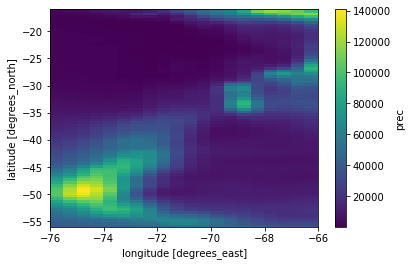

In [79]:
display(ds)
(ds.prec.sum(dim='time')/100.).plot()

## Convert files to final LPJ-GUESS compressed format

In [100]:
# land ids for entire chile simulation domain
ds_landids = xr.open_dataset("land_ids_2d_wha.nc")
ds_landids

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 20)
Coordinates:
  * lon      (lon) float64 -75.75 -75.25 -74.75 -74.25 ... -67.25 -66.75 -66.25
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... -17.25 -16.75 -16.25
Data variables:
    land_id  (lat, lon) float64 ...

In [81]:
NODATA = -9999
defaultD = {'missing_value': NODATA, '_FillValue': NODATA, 'coordinates': "lat lon"}

def is_3d(ds, v):
    """Check if xr.DataArray has 3 dimensions."""
    dims = ds[v].dims
    if len(dims) == 3:
        return True
    return False

def build_compressed(ds, landids, v):
    """Build LPJ-Guess 4.0 compatible compressed netcdf file."""
    # identify landforms netcdf

    # create id position dataarray
    da_ids = xr.ones_like(ds[v]) * NODATA

    latL = []
    lonL = []
    d = ds[v].to_masked_array()
    
    # REVIEW: why is 'to_masked_array()'' not working here?
    d = np.ma.masked_where(d == NODATA, d)
    
    # read land ids from landids dataset
    D_ids = OrderedDict()
    d_landids = landids['land_id'].to_masked_array()
    
    land_id = 0
    for j in reversed(range(len(d[0]))):
        for i in range(len(d[0,0])):
            if d_landids[j, i] is not np.ma.masked:
                lat = float(ds['lat'][j].values)
                lon = float(ds['lon'][i].values)
                latL.append(lat)
                lonL.append(lon)
                #da_ids.loc[lat, lon] = landids['land_id'].sel(lat=[lat], lon=[lon])
                x = landids['land_id'].sel(lat=lat, lon=lon).values
                D_ids[(lat, lon)] = x
                
                land_id += 1 

    LFIDS = range(land_id) 
    
    # create coordinate variables
    _blank = np.zeros(len(LFIDS))
    lats = xr.DataArray(latL, name='lat', coords=[('land_id', LFIDS)])
    lons = xr.DataArray(lonL, name='lon', coords=[('land_id', LFIDS)])

    # add attributes
    lats.attrs['standard_name'] = "latitude"
    lats.attrs['long_name'] = "latitude"
    lats.attrs['units'] = "degrees_north"

    lons.attrs['standard_name'] = "longitude"
    lons.attrs['long_name'] = "longitude"
    lons.attrs['units'] = "degrees_east"

    # create xr.Dataset
    dsout = xr.Dataset()
    dsout[lats.name] = lats
    dsout[lons.name] = lons

    # walk through variables, get lat/ lon cells' data 
    #for v in ds.data_vars:
    if is_3d(ds, v):
        _shape = (len(LFIDS), len(ds[ds[v].dims[0]]))
        COORDS = [('land_id', LFIDS), ('time', ds.coords['time'])]
    else:
        _shape = (len(LFIDS),)
        COORDS = [('land_id', LFIDS)]

    _blank = np.ones( _shape )
    _da = xr.DataArray(_blank[:], name=v, coords=COORDS)

    for lat, lon in zip(latL, lonL):
        land_id = D_ids[(lat, lon)]
        vals = ds[v].sel(lat=lat, lon=lon).to_masked_array().filled(NODATA)
        _da.loc[land_id] = vals

    _da.attrs.update( ds[v].attrs )
    _da.attrs.update(defaultD)

    dsout[_da.name] = _da

    return dsout

Convert all time-slices

In [82]:
for ts in ['pliocene', 'middle_miocene', 'pre_industrial', 'lgm', 'late_miocene', 'middle_holocene']:
    print(ts)
    
    ds = xr.open_dataset(f'biascorrected3/new_echam5_{ts}_daily.nc', decode_times=False)

    for var in ['prec', 'temp', 'rad']:
        dc = build_compressed(ds, ds_landids, var)

        # fix attributes
        dc['time'].attrs['units'] = "days since 1-1-15 00:00:00"
        dc['time'].attrs['axis'] = "T"
        dc['time'].attrs['long_name'] = "time"
        dc['time'].attrs['standard_name'] = "time"
        dc['time'].attrs['calendar'] = "%d yr B.P." % 1_000

        #dc[var].attrs['coordinates'] = "lat lon"
        #if var == 'prec':
        #    dc['wet'].attrs['coordinates'] = "lat lon"

        outname = f"final/new_echam5_{ts}_{var}_landid.nc"
        dc.to_netcdf(outname, format='NETCDF4_CLASSIC', unlimited_dims=['time'])

pliocene
middle_miocene
pre_industrial
lgm
late_miocene
middle_holocene


In [87]:
! ls -l final/*.nc
! tar cvfz new_final.tgz final

-rw-r--r-- 1 root root 316238272 Jul 18 08:28 final/new_echam5_late_miocene_prec_landid.nc
-rw-r--r-- 1 root root 316238338 Jul 18 08:28 final/new_echam5_late_miocene_rad_landid.nc
-rw-r--r-- 1 root root 316238272 Jul 18 08:28 final/new_echam5_late_miocene_temp_landid.nc
-rw-r--r-- 1 root root 316238272 Jul 18 08:28 final/new_echam5_lgm_prec_landid.nc
-rw-r--r-- 1 root root 316238338 Jul 18 08:28 final/new_echam5_lgm_rad_landid.nc
-rw-r--r-- 1 root root 316238272 Jul 18 08:28 final/new_echam5_lgm_temp_landid.nc
-rw-r--r-- 1 root root 316238272 Jul 18 08:28 final/new_echam5_middle_holocene_prec_landid.nc
-rw-r--r-- 1 root root 316238338 Jul 18 08:28 final/new_echam5_middle_holocene_rad_landid.nc
-rw-r--r-- 1 root root 316238272 Jul 18 08:28 final/new_echam5_middle_holocene_temp_landid.nc
-rw-r--r-- 1 root root 316238272 Jul 18 08:27 final/new_echam5_middle_miocene_prec_landid.nc
-rw-r--r-- 1 root root 316238338 Jul 18 08:27 final/new_echam5_middle_miocene_rad_landid.nc
-rw-r--r-- 1 root

### Extract data for the four focus site locations (grid cells)

In [119]:
sites = ['PandeAzucar', 'StaGracia', 'LaCampana', 'Nahuelbuta']
ids   = [207, 283, 355, 490]

for i, site in zip(ids, sites):
    for ts in tss:
        if ts == 'present_day':
            continue
        for var in ['prec', 'temp', 'rad']:
            print(i, ts, var)
            with xr.open_dataset(f"final/new_echam5_{ts}_{var}_landid.nc", decode_times=False) as ds:
                ds = ds.sel(land_id=[i], drop=False)

                # hackery to replace the original land_id with the default land_id of 0 for all files
                ds['land_id_new'] = xr.DataArray([0], dims=['land_id'])
                ds.swap_dims({'land_id': 'land_id_new'}, inplace=True)
                del ds['land_id']
                ds.rename({'land_id_new': 'land_id'}, inplace=True)
                
                # write file
                ds.to_netcdf(f"final_sites/echam5_{ts}_{site}_{var}.nc")
                

207 pre_industrial prec


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


207 pre_industrial temp
207 pre_industrial rad
207 middle_miocene prec
207 middle_miocene temp
207 middle_miocene rad
207 middle_holocene prec
207 middle_holocene temp
207 middle_holocene rad
207 late_miocene prec
207 late_miocene temp
207 late_miocene rad
207 pliocene prec
207 pliocene temp
207 pliocene rad
207 lgm prec
207 lgm temp
207 lgm rad
283 pre_industrial prec
283 pre_industrial temp
283 pre_industrial rad
283 middle_miocene prec
283 middle_miocene temp
283 middle_miocene rad
283 middle_holocene prec
283 middle_holocene temp
283 middle_holocene rad
283 late_miocene prec
283 late_miocene temp
283 late_miocene rad
283 pliocene prec
283 pliocene temp
283 pliocene rad
283 lgm prec
283 lgm temp
283 lgm rad
355 pre_industrial prec
355 pre_industrial temp
355 pre_industrial rad
355 middle_miocene prec
355 middle_miocene temp
355 middle_miocene rad
355 middle_holocene prec
355 middle_holocene temp
355 middle_holocene rad
355 late_miocene prec
355 late_miocene temp
355 late_miocene rad

In [104]:
! ncdump -sch final_sites/echam5_pliocene_LaCampana_prec.nc

netcdf echam5_pliocene_LaCampana_prec {
dimensions:
	time = UNLIMITED ; // (36500 currently)
	land_id = 1 ;
variables:
	int land_id(land_id) ;
		land_id:_Storage = "contiguous" ;
		land_id:_Endianness = "little" ;
	double lat(land_id) ;
		lat:_FillValue = NaN ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lon(land_id) ;
		lon:_FillValue = NaN ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:_Storage = "contiguous" ;
		lon:_Endianness = "little" ;
	double time(time) ;
		time:_FillValue = NaN ;
		time:units = "days since 1-1-15 00:00:00" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:calendar = "1000 yr B.P." ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 512 ;
		time:_Endianness = "little" ;
	double prec(land_id, time) ;
		prec:_FillValue = -9999. ;
		prec:stan